In [ ]:
import torch
import torch.nn as nn
import diffusers
import matplotlib.pyplot as plt
import torchvision
from ema_pytorch import EMA
import tqdm.notebook as tqdm


In [2]:
dataset  = torchvision.datasets.ImageFolder("data/celeba_hq/train", transform=torchvision.transforms.Compose([
    torchvision.transforms.Resize((128, 128)),
    torchvision.transforms.ToTensor()
])
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


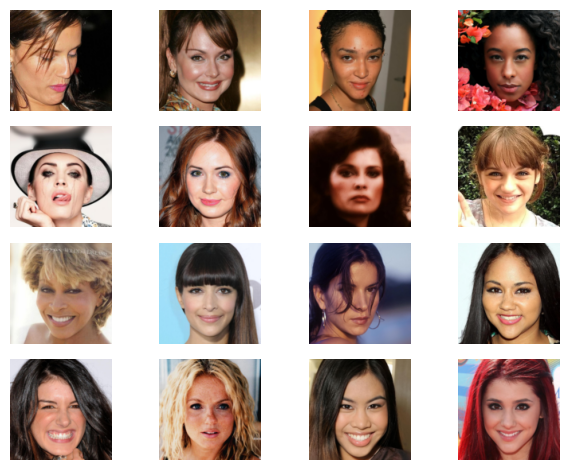

In [3]:
# Plot some images
fig, axs = plt.subplots(4, 4)

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(dataset[i*4+j][0].permute(1, 2, 0))
        axs[i, j].axis("off")
        

plt.tight_layout()
plt.show()


In [4]:
scheduler = diffusers.DDIMScheduler(
    num_train_timesteps=1000,
    rescale_betas_zero_snr=True,
)


In [17]:
model = diffusers.UNet2DModel(
    sample_size=(128, 128),
    in_channels=3,
    out_channels=3,
    down_block_types=("DownBlock2D", "DownBlock2D",  "DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"), # "DownBlock2D", "AttnDownBlock2D", 
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D","UpBlock2D", "UpBlock2D", "UpBlock2D"), # "UpBlock2D", "AttnUpBlock2D",
    block_out_channels=(32, 64, 128, 256, 256),
    layers_per_block=2,
)


In [18]:
print(f"Model has {model.num_parameters():,} parameters.")


Model has 26,211,139 parameters.


In [7]:
device ="cuda"


In [8]:
model = model.to(device)


In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)


In [10]:
ema = EMA(model, beta=0.9999, update_after_step=500, update_every=50)


In [11]:
def generate():
    # Plot some images
    model.eval()
    pipeline = diffusers.DDIMPipeline(model, scheduler)

    with torch.no_grad():
        imgs = pipeline(
            batch_size=8,
            num_inference_steps=50,
            output_type='pil',
            eta=1
        ).images
        
    fig, axs = plt.subplots(1, 8, figsize=(16, 4))

    for i in range(8):
        axs[i].imshow(imgs[i])
        axs[i].axis("off")
        
    plt.tight_layout()
    plt.show()
    model.train()


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

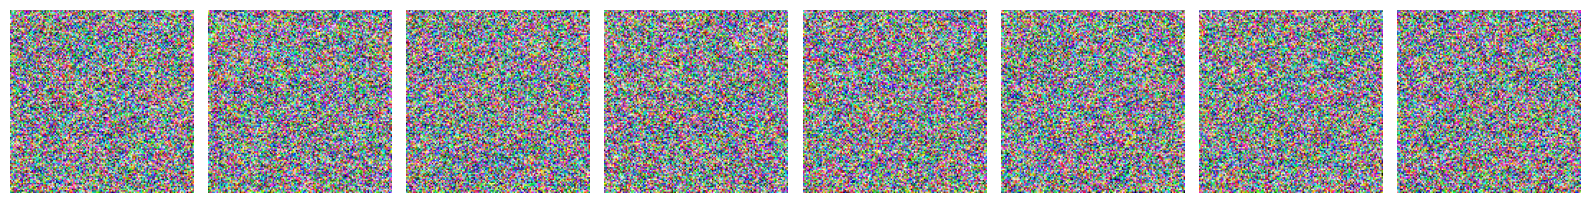

  0%|          | 0/875 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [12]:
# Train the model
with tqdm.tnrange(10) as epochs:
    for epoch in epochs:
        generate()
        for i, (x, _) in enumerate(tqdm.tqdm(dataloader)):
            x = x.to(device)
            
            noise = torch.randn_like(x, device=device)
            timestep = torch.randint(0, 1000, (x.shape[0],), device=device)

            noisy_image = scheduler.add_noise(x, noise, timestep)

            model_output = model(noisy_image, timestep).sample

            loss = torch.nn.functional.l1_loss(model_output, x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            epochs.set_postfix(loss=loss.item())
            ema.update()


  0%|          | 0/50 [00:00<?, ?it/s]

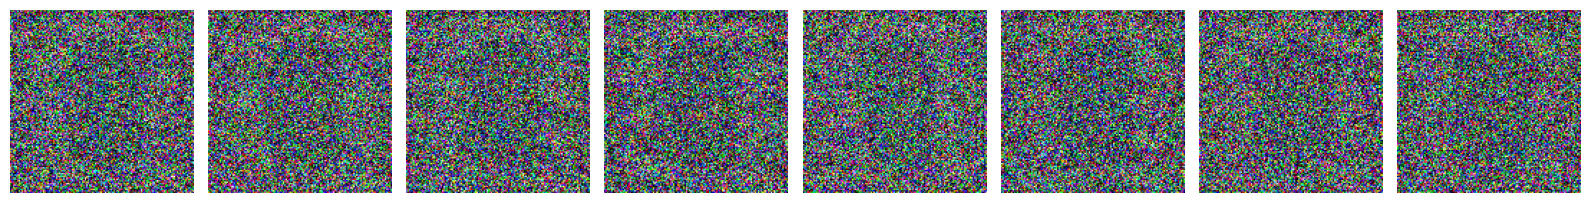

In [13]:
generate()


In [19]:
pipeline = diffusers.DDIMPipeline(model, scheduler)
imgs = pipeline(
    batch_size=8,
    num_inference_steps=50,
    output_type='np',
    eta=1
).images

print(imgs.shape)


  0%|          | 0/50 [00:00<?, ?it/s]

(8, 128, 128, 3)


[[[[8.14734817e-01 9.43469763e-01 5.68549335e-02]
   [4.20965761e-01 3.88997793e-03 8.97283792e-01]
   [6.10742807e-01 3.68930578e-01 4.09984559e-01]
   ...
   [7.29323208e-01 7.85280108e-01 1.00000000e+00]
   [6.96881711e-02 4.51244473e-01 6.97388530e-01]
   [5.01692772e-01 4.09408927e-01 1.66353583e-03]]

  [[9.56214428e-01 0.00000000e+00 4.02012169e-01]
   [1.88317299e-02 1.44845039e-01 5.11721671e-02]
   [9.30764318e-01 8.19403827e-01 6.96261287e-01]
   ...
   [4.26112235e-01 5.87203026e-01 2.12206274e-01]
   [4.65101510e-01 3.08044404e-01 9.44038928e-02]
   [1.57364011e-02 5.58702052e-01 3.19435894e-02]]

  [[1.00000000e+00 2.71840572e-01 2.18379676e-01]
   [9.65039849e-01 9.07031298e-01 3.11370373e-01]
   [1.09171182e-01 8.33680630e-02 7.98073232e-01]
   ...
   [7.67126203e-01 5.82724512e-02 3.92568052e-01]
   [1.47768110e-01 9.52777505e-01 6.52595818e-01]
   [3.86301994e-01 1.13073379e-01 1.23870641e-01]]

  ...

  [[8.65511596e-02 4.75690246e-01 1.68159604e-03]
   [2.48275131e-

In [16]:
pipeline = diffusers.DDIMPipeline(model, scheduler)
imgs = pipeline(
    batch_size=8,
    num_inference_steps=50,
    output_type='np',
    eta=1
).images
x, _ = next(iter(dataloader))

from torchmetrics.image.fid import FrechetInceptionDistance

fid = FrechetInceptionDistance(2048)

imgs = torch.tensor(imgs).permute(0, 3, 1, 2)

# Resize to 299x299
imgs = torch.nn.functional.interpolate(imgs, size=(299, 299), mode="bilinear", align_corners=False)
x = torch.nn.functional.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)

# make uint8
imgs = (imgs * 255).to(torch.uint8)
x = (x * 255).to(torch.uint8)

fid.update(imgs, False)

fid.update(x, True)
print(fid.compute())


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(479.4950)


In [23]:
print(scheduler)


DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": true,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}



In [ ]:
torch.save(model.state_dict(), "projects/paper-implementations/image-generation/diffusion/celeba_hq_model.pth")
